In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# to output everything in a cell instead of only the last output
# 这两行代码用来设置 IPython 的交互模式，允许在一个单元格中显示多个输出，而不仅仅是最后一个输出。


%matplotlib inline
# 这行命令用于在 Jupyter 笔记本中内嵌绘图，使得生成的图表可以直接显示在笔记本中

# standard imports
import numpy as np
import matplotlib.pyplot as plt

# import numpy as np：导入 NumPy 库，用于处理数值型数据。
# import xarray as xr：导入 xarray 库，这是一个用于处理多维数组数据（如气象数据）的强大工具。
# import matplotlib.pyplot as plt：导入 matplotlib 的 pyplot 模块，这是 Python 中一个常用的绘图库。
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.python.keras.utils.np_utils import to_categorical

In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np

# 在导入 TensorFlow 或任何操作之前设置 GPU 配置
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')  # 仅使用第一个 GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)  # 动态分配显存
        print("Using GPU for training.")
    except RuntimeError as e:
        print("GPU configuration error:", e)

Using GPU for training.


In [3]:
#海平面异常数据
Seg_train = np.expand_dims(np.load(r'D:\jupyterProject\eddy\data\2001_2022\AugmentationData\trainEddy_nanhai_Augmentation_2001_2022.npy'),3) #you can use all the region, in here I selected a box of 168*168 size
# np.expand_dims(..., 3)：expand_dims 函数用于在数组中增加一个新的轴。参数 3 表示新轴被添加在原数组的第四个维度（索引从0开始）。这通常用于确保数据的维度与某些特定的数据处理或机器学习模型的输入要求相匹配。
#######
#旋涡数据
SSH_train = np.expand_dims(np.load(r'D:\jupyterProject\eddy\data\2001_2022\AugmentationData\trainSla_nanhai_Augmentation_2001_2022.npy'),3)

######
#图像数量，图像大小（高，宽），通道数
SSH_train.shape
#####
Seg_train.shape
mask= np.load(r'D:\jupyterProject\eddy\data\2001_2022\mask\mask_nanhai_2001_2022.npy')
mask.shape
# 第四个维度为 1，表示这些图像是单通道的，即灰度图像（与彩色图像相比，彩色图像通常有三个通道表示红、绿、蓝）。

# 总数据大小
total_images = SSH_train.shape[0]
# 随机选取 7300 个索引
random_indices = np.random.choice(total_images, 11000, replace=False)
# 根据随机选择的索引，从 SSH_train 和 Seg_train 中选取对应的图像。这样可以减少数据量，使得模型训练在合理的时间内完成，同时确保训练数据的多样性
# 选取对应的图像
SSH_train = SSH_train[random_indices]
Seg_train = Seg_train[random_indices]
mask = mask[random_indices]

SSH_train.shape
Seg_train.shape
mask.shape

max(random_indices)
mask[1]
Seg_train_categor = to_categorical(np.reshape(Seg_train[:,:,:,0],(11000,88*80)),3)#去除最后一个维度（通道维度），reshape成（7000*96*96）大小，并进行独热编码，类型有3种

(32140, 88, 80, 1)

(32140, 88, 80, 1)

(32140, 88, 80)

(11000, 88, 80, 1)

(11000, 88, 80, 1)

(11000, 88, 80)

32136

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [4]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Activation, Reshape, Permute, Lambda, 
    Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, AlphaDropout, 
    concatenate, Conv2DTranspose, 
    BatchNormalization, LeakyReLU, add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.layers import Layer

import matplotlib.pyplot as plt
import numpy as np
import pickle
from IPython.display import SVG

In [5]:
# 假设 Seg_train 已经被定义并且是一个四维数组，形状为 (7300, 128, 128, 1)
# 这段代码将 Seg_train 数据转换为分类格式，并输出转换后的形状。
# Seg_train[:,:,:,0]：获取 Seg_train 的第一个通道数据，形状为 (7300, 128, 128)。
# np.reshape(..., (7300, 128*128))：将 Seg_train 重塑为 (7300, 128*128) 的二维数组，每张图像的大小从 128x128 变为 16384 的一维数组。
# to_categorical(..., 3)：将重塑后的 Seg_train 转换为分类格式。3 表示类别的数量，因此输出将是一个 (7300, 128*128, 3) 的数组，
# 每个像素点用一个3维的one-hot向量表示类别。

Seg_train_categor = to_categorical(np.reshape(Seg_train[:,:,:,0], (11000, 88*80)), 3)

# 输出 Seg_train_categor 的形状，以确认转换后的数据格式。
print(Seg_train_categor.shape)

(11000, 7040, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models,Input,Model

def FirstResUnit(nf,ker,inputs):
    conv1 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv1)
    return add([conv2,inputs])

def ResUnit(nf,ker,inputs, drop=0.5):
    conv1 = BatchNormalization()(inputs)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(drop)(conv1)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(drop)(conv2)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv2)
    shortcut = Conv2D(nf, 1, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)#由于前面的操作改变了通道数，导致最初的input和改变通道数了的conv2无法加在一起，所以这里将inputs的通道数也变为ker大小
    return add([conv2,shortcut])

def ResUnitDecoder(nf,ker,inputs,drop=0.5):
    conv1 = BatchNormalization()(inputs)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(drop)(conv1)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(drop)(conv2)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv2)
    ###
    shortcut = Conv2D(nf, 1, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    return add([conv2,shortcut])
# FPN相关的辅助函数
def create_fpn_top_layer(nf, inputs):
    conv = Conv2D(nf, (1, 1), padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    return conv


class Attention_block(Layer):
    def __init__(self, F_g, F_l, F_int, **kwargs):
        super(Attention_block, self).__init__(**kwargs)
        self.F_g = F_g
        self.F_l = F_l
        self.F_int = F_int
        
        self.W_g = tf.keras.Sequential([
            Conv2D(F_int, kernel_size=1, strides=1, padding="valid", use_bias=True),
            BatchNormalization()
        ])
        self.W_x = tf.keras.Sequential([
            Conv2D(F_int, kernel_size=1, strides=1, padding="valid", use_bias=True),
            BatchNormalization()
        ])
        self.psi = tf.keras.Sequential([
            Conv2D(1, kernel_size=1, strides=1, padding="valid", use_bias=True),
            BatchNormalization(),
            Activation('sigmoid')
        ])
        self.relu = Activation('relu')

    def call(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

    def get_config(self):
        config = super(Attention_block, self).get_config()
        config.update({
            'F_g': self.F_g,
            'F_l': self.F_l,
            'F_int': self.F_int,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

def create_lateral_connection_with_attention(nf, top_layer, lateral_layer):
    print(top_layer.shape)
    print(lateral_layer.shape)
    # 创建1x1卷积调整通道数
    lateral = Conv2D(nf, (1, 1), padding="same", kernel_initializer='he_normal', use_bias=False)(lateral_layer)
    upsampled = UpSampling2D((2, 2))(top_layer)

    # 使用Attention block来处理融合前的特征图
    attention_block = Attention_block(F_g=nf, F_l=nf, F_int=nf//2)
    merged = attention_block(upsampled, lateral)  # 注意力机制应用于融合之前的两个特征图

    return merged

In [7]:
width = 80
height = 88
nbClass = 3
ker = 3

img_input = Input(shape=(height, width, 1))

# 编码器和中心部分（保持不变）
conv1 = FirstResUnit(32, ker, img_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = ResUnit(64, ker, pool1, drop=0.3)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = ResUnit(128, ker, pool2, drop=0.4)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

convC = ResUnit(256, ker, pool3, drop=0.5)
fpn_top = create_fpn_top_layer(256, convC)

print("fpn_top",fpn_top.shape)
print("conv3",conv3.shape)

# 添加注意力模块
fpn_p3 = create_lateral_connection_with_attention(256, fpn_top, conv3)
fpn_p2 = create_lateral_connection_with_attention(256, fpn_p3, conv2)
fpn_p1 = create_lateral_connection_with_attention(256, fpn_p2, conv1)

# 解码器更新
up3 = concatenate([UpSampling2D((2, 2))(fpn_top), fpn_p3])
decod3 = ResUnitDecoder(256, ker, up3, drop=0.5)

up2 = concatenate([UpSampling2D((2, 2))(decod3), fpn_p2])
decod2 = ResUnitDecoder(128, ker, up2, drop=0.4)

up1 = concatenate([UpSampling2D((2, 2))(decod2), fpn_p1])
decod1 = ResUnitDecoder(64, ker, up1, drop=0.3)

decod0 = ResUnitDecoder(32, ker, decod1, drop=0.3)

# 输出层（保持不变）
x = Conv2D(nbClass, (1, 1), padding="valid", use_bias=False)(decod0)
x = Reshape((height * width, nbClass))(x) 
x = Activation("softmax")(x)

eddynet = Model(img_input, x)

eddynet.summary()

fpn_top (None, 11, 10, 256)
conv3 (None, 22, 20, 128)
(None, 11, 10, 256)
(None, 22, 20, 128)
(None, 22, 20, 256)
(None, 44, 40, 64)
(None, 44, 40, 256)
(None, 88, 80, 32)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 88, 80, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 88, 80, 32)   288         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 88, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                     

 activation_6 (Activation)      (None, 11, 10, 256)  0           ['batch_normalization_6[0][0]']  
                                                                                                  
 dropout_5 (Dropout)            (None, 11, 10, 256)  0           ['activation_6[0][0]']           
                                                                                                  
 conv2d_9 (Conv2D)              (None, 11, 10, 256)  589824      ['dropout_5[0][0]']              
                                                                                                  
 conv2d_10 (Conv2D)             (None, 11, 10, 256)  32768       ['max_pooling2d_2[0][0]']        
                                                                                                  
 add_3 (Add)                    (None, 11, 10, 256)  0           ['conv2d_9[0][0]',               
                                                                  'conv2d_10[0][0]']              
          

 up_sampling2d_2 (UpSampling2D)  (None, 88, 80, 256)  0          ['attention_block_1[0][0]']      
                                                                                                  
 conv2d_20 (Conv2D)             (None, 88, 80, 256)  8192        ['add[0][0]']                    
                                                                                                  
 up_sampling2d_5 (UpSampling2D)  (None, 88, 80, 128)  0          ['add_5[0][0]']                  
                                                                                                  
 attention_block_2 (Attention_b  (None, 88, 80, 256)  66949      ['up_sampling2d_2[0][0]',        
 lock)                                                            'conv2d_20[0][0]']              
                                                                                                  
 concatenate_2 (Concatenate)    (None, 88, 80, 384)  0           ['up_sampling2d_5[0][0]',        
          

In [8]:

# 这段代码用于计算分割数据集中每个类别的权重，以处理数据不平衡的问题。以下是详细解释

unique, counts = np.unique(Seg_train, return_counts=True)
# np.unique(Seg_train, return_counts=True)：
# 这个函数会返回数组 Seg_train 中的唯一值和每个唯一值的计数。
# unique 是唯一值的数组，counts 是每个唯一值对应的计数。

dict(zip(unique, counts))
# dict(zip(unique, counts))：
# 将 unique 和 counts 转换成字典格式，其中键是唯一值，值是对应的计数。
# 这使得我们能够更方便地查看每个类别在数据集中的数量。

# 根据您提供的结果 {0: 95145706, 1: 11705580, 2: 12751914}，
# 我们可以看到类别 0 的像素点数量明显多于类别 1 和类别 2。
# 为了处理这种数据不平衡，我们需要计算每个类别的权重，
# 以便在训练过程中能够平衡各个类别的影响
# gpt提供了另外一种计算权重的方式

{0: 67296222, 1: 4889237, 2: 5254541}

In [9]:
# 您在使用一个不同的方法来计算类别的权重。
# 这段代码先计算每个类别出现频率的倒数，然后对这些频率进行归一化处理

freq = [np.sum(counts)/j for j in counts]
# np.sum(counts) 计算所有类别的像素点总数。
# 对于每个类别的计数 j，计算总像素点数与 j 的比值。
# 这给出了类别频率的倒数，表示较少出现的类别会有更高的权重。

weightsSeg = [f/np.sum(freq) for f in freq]
# 计算频率倒数的总和 np.sum(freq)。
# 对每个频率倒数 f，将其除以频率倒数的总和，从而进行归一化处理。这保证了所有权重的和为 1。

weightsSeg

[0.036269458973017414, 0.4992185003238894, 0.4645120407030932]

In [10]:
# 这段代码定义了一系列用于计算 Dice 系数及其加权版本的函数，
# 并定义了一个基于加权平均 Dice 系数的损失函数。
# Dice 系数是一种用于评估两个样本相似度的统计方法，
# 特别适用于图像分割任务。Dice 系数的取值范围是 [0, 1]，其中 1 表示完全重合，
# 0 表示完全不重合。
# 这段代码定义并使用了一组基于 Dice 系数的指标和损失函数，特别适用于图像分割任务。
# 通过这些定义，模型能够更好地处理数据不平衡问题，并提供更加直观和有效的评估标准。
import tensorflow as tf


smooth = 1.  # to avoid zero division
# 用于避免除零错误，在计算 Dice 系数时加到分子和分母中。


# 反气旋涡
def dice_coef_anti(y_true, y_pred):
    y_true_anti = y_true[:,:,2]
    y_pred_anti = y_pred[:,:,2]
    intersection_anti = tf.reduce_sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (tf.reduce_sum(y_true_anti)+ tf.reduce_sum(y_pred_anti) + smooth)
# 提取类别 2(anti) 的真实值和预测值。
# 计算交集（相乘后求和）。
# 计算 Dice 系数。



# 气旋涡
def dice_coef_cyc(y_true, y_pred):
    y_true_cyc = y_true[:,:,1]
    y_pred_cyc = y_pred[:,:,1]
    intersection_cyc = tf.reduce_sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (tf.reduce_sum(y_true_cyc) + tf.reduce_sum(y_pred_cyc) + smooth)
# 类似于 dice_coef_anti，但针对类别 1 (cyc)。




# 没有涡旋
def dice_coef_nn(y_true, y_pred):
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = tf.reduce_sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (tf.reduce_sum(y_true_nn) + tf.reduce_sum(y_pred_nn) + smooth)
# 类似于 dice_coef_anti，但针对类别 0 (nn)。    
    
    
    
# Mean Dice 系数
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.
# 计算三种类别 Dice 系数的平均值。



# 加权 Mean Dice 系数：
def weighted_mean_dice_coef(y_true, y_pred):
    return (0.46289*dice_coef_anti(y_true, y_pred) + 0.50085*dice_coef_cyc(y_true, y_pred) + 0.03626*dice_coef_nn(y_true, y_pred))
# 根据类别重要性加权计算 Dice 系数。


# dice损失
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)
# 基于加权平均 Dice 系数定义损失函数，损失值越小表示预测与真实值越接近。

In [11]:
# 编译模型的代码

# 在 Keras 中，编译模型时需要指定优化器、损失函数和评估指标。您的代码中使用了以下组件：
# optimizer=Adam(learning_rate=1e-3)   
# Adam：一种常用的优化算法，适用于处理稀疏梯度和大规模数据。
# learning_rate=1e-3：设置学习率为 0.001，控制每次参数更新的步长。

# 损失函数,loss=dice_coef_loss
# dice_coef_loss：基于 Dice 系数定义的损失函数，用于优化模型时计算误差。
# Dice 损失特别适用于图像分割任务，因为它直接衡量了预测结果与真实标签的重叠程度。

# 评估指标:metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef]
# categorical_accuracy：分类准确度，用于评估多类别分类任务的性能。
# 计算预测类别与真实类别匹配的比例。
# mean_dice_coef：自定义的平均 Dice 系数，衡量所有类别的平均分割效果。
# weighted_mean_dice_coef：自定义的加权平均 Dice 系数，按照类别重要性加权计算，
# 进一步衡量分割效果。
    
# eddynet.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_coef_loss,
#                 metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

eddynet.compile(optimizer=Adam(learning_rate=6e-5), loss=dice_coef_loss,
                metrics=['categorical_accuracy', dice_coef_anti, dice_coef_cyc, dice_coef_nn, mean_dice_coef, weighted_mean_dice_coef])


# mean_dice_coef：计算三个类别（反向涡旋、顺时针涡旋和无涡旋）的 Dice 系数的平均值。

# weighted_mean_dice_coef：按照类别重要性加权计算三个类别的 Dice 系数，
# 其中反向涡旋占 36%，顺时针涡旋占 62%，无涡旋占 2%。


# 编译模型：指定了 Adam 优化器、基于 Dice 系数的损失函数和多个评估指标。
# 优化器：Adam 优化器，学习率为 0.001。
# 损失函数：自定义的 Dice 损失函数，用于图像分割任务。
# 评估指标：包括分类准确度、平均 Dice 系数和加权平均 Dice 系数。
# 通过这些设置，您能够在训练过程中使用加权 Dice 损失函数来优化模型，
# 并通过分类准确度和 Dice 系数来评估模型的性能。
# 这种设置特别适合处理图像分割任务，尤其是在数据不平衡的情况下。

In [12]:
# modelcheck = ModelCheckpoint(r'D:\01毕设\4 EddyNet-master\EddyNet-master\EddyNet_new\权重\eddynet6.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
# reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)


# histeddynet=eddynet.fit(SSH_train, Seg_train_categor,
#                               epochs=50,
#                               batch_size=16,
#                               shuffle=True,
#                               verbose=1,
#                               callbacks=[modelcheck,reducecall],#,MyCallback(alpha,beta),reducecall
#                               validation_split=0.2
#                               )


# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# modelcheck = ModelCheckpoint(r'D:\01毕设\4 EddyNet-master\EddyNet-master\EddyNet_new\权重\eddynet6.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
# reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)

# histeddynet = eddynet.fit(SSH_train, Seg_train_categor,
#                           epochs=50,
#                           batch_size=16,
#                           shuffle=True,
#                           verbose=1,
#                           callbacks=[modelcheck, reducecall],
#                           validation_split=0.2)



modelcheck = ModelCheckpoint(r'D:\EddyNet\EddyNet-master\EddyNet_new\weights\ResNet_FPN_Attention_6e_5.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False)
# 功能：在训练过程中保存模型的权重。
# 参数：
# filepath：保存模型权重的路径。
# monitor：监控的指标，这里是验证损失（val_loss）。
# verbose：日志详细度，设置为 1 会在每次模型保存时输出信息。
# save_best_only：如果为 True，则只保存监控指标（这里是验证损失）最好的模型。
# save_weights_only：如果为 True，则只保存模型的权重，而不保存模型的结构。



reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='auto', min_delta=1e-7, min_lr=5e-9)
# 功能：当监控的指标（这里是验证损失）在一定次数（patience）的训练周期中没有改善时，
# 减少学习率。
# 参数：
# monitor：监控的指标，这里是验证损失（val_loss）。
# factor：当指标停止改善时，学习率减少的因子，新的学习率将是 learning_rate = learning_rate * factor。
# patience：当 patience 个训练周期过去而指标没有改善时，学习率将减小。
# verbose：日志详细度，设置为 1 会在每次学习率减小时输出信息。
# mode：决定在何种情况下监控的指标会被认为是改善了，可以是 auto，min，或 max。
# min_delta：在监控指标的变化量小于 min_delta 时，认为没有改善。
# min_lr：学习率的下限。

In [13]:
# 训练模型
histeddynet=eddynet.fit(SSH_train, Seg_train_categor,
                              epochs=80,
                              batch_size=8,
                              shuffle=True,
                              verbose=1,
                              callbacks=[modelcheck,reducecall],#,MyCallback(alpha,beta),reducecall
                              validation_split=0.2
                              )
 
# 保存训练历史记录
with open('train_history_ResNet_FPN_Attention_6e_5.npy', 'wb') as f:
    np.save(f, histeddynet.history)

Epoch 1/80
1100/1100 [==============================] - ETA: 0s - loss: 0.4347 - categorical_accuracy: 0.8764 - dice_coef_anti: 0.5638 - dice_coef_cyc: 0.5404 - dice_coef_nn: 0.9277 - mean_dice_coef: 0.6773 - weighted_mean_dice_coef: 0.5653
Epoch 1: val_loss improved from inf to 0.48624, saving model to D:\EddyNet\EddyNet-master\EddyNet_new\weights\ResNet_FPN_Attention_6e_5.keras
1100/1100 [==============================] - 135s 108ms/step - loss: 0.4347 - categorical_accuracy: 0.8764 - dice_coef_anti: 0.5638 - dice_coef_cyc: 0.5404 - dice_coef_nn: 0.9277 - mean_dice_coef: 0.6773 - weighted_mean_dice_coef: 0.5653 - val_loss: 0.4862 - val_categorical_accuracy: 0.7748 - val_dice_coef_anti: 0.4851 - val_dice_coef_cyc: 0.5156 - val_dice_coef_nn: 0.8540 - val_mean_dice_coef: 0.6182 - val_weighted_mean_dice_coef: 0.5138 - lr: 6.0000e-05
Epoch 2/80
1100/1100 [==============================] - ETA: 0s - loss: 0.3600 - categorical_accuracy: 0.8990 - dice_coef_anti: 0.6383 - dice_coef_cyc: 0.619

Epoch 11/80
1100/1100 [==============================] - ETA: 0s - loss: 0.2394 - categorical_accuracy: 0.9348 - dice_coef_anti: 0.7589 - dice_coef_cyc: 0.7476 - dice_coef_nn: 0.9623 - mean_dice_coef: 0.8229 - weighted_mean_dice_coef: 0.7606
Epoch 11: val_loss improved from 0.25289 to 0.25044, saving model to D:\EddyNet\EddyNet-master\EddyNet_new\weights\ResNet_FPN_Attention_6e_5.keras
1100/1100 [==============================] - 118s 107ms/step - loss: 0.2394 - categorical_accuracy: 0.9348 - dice_coef_anti: 0.7589 - dice_coef_cyc: 0.7476 - dice_coef_nn: 0.9623 - mean_dice_coef: 0.8229 - weighted_mean_dice_coef: 0.7606 - val_loss: 0.2504 - val_categorical_accuracy: 0.9217 - val_dice_coef_anti: 0.7411 - val_dice_coef_cyc: 0.7426 - val_dice_coef_nn: 0.9536 - val_mean_dice_coef: 0.8124 - val_weighted_mean_dice_coef: 0.7496 - lr: 6.0000e-05
Epoch 12/80
1100/1100 [==============================] - ETA: 0s - loss: 0.2342 - categorical_accuracy: 0.9361 - dice_coef_anti: 0.7640 - dice_coef_cyc

1100/1100 [==============================] - ETA: 0s - loss: 0.1922 - categorical_accuracy: 0.9481 - dice_coef_anti: 0.8068 - dice_coef_cyc: 0.7970 - dice_coef_nn: 0.9700 - mean_dice_coef: 0.8579 - weighted_mean_dice_coef: 0.8078
Epoch 31: val_loss did not improve from 0.18904
1100/1100 [==============================] - 118s 108ms/step - loss: 0.1922 - categorical_accuracy: 0.9481 - dice_coef_anti: 0.8068 - dice_coef_cyc: 0.7970 - dice_coef_nn: 0.9700 - mean_dice_coef: 0.8579 - weighted_mean_dice_coef: 0.8078 - val_loss: 0.1912 - val_categorical_accuracy: 0.9448 - val_dice_coef_anti: 0.8153 - val_dice_coef_cyc: 0.7913 - val_dice_coef_nn: 0.9677 - val_mean_dice_coef: 0.8581 - val_weighted_mean_dice_coef: 0.8088 - lr: 3.0000e-05
Epoch 32/80
1100/1100 [==============================] - ETA: 0s - loss: 0.1914 - categorical_accuracy: 0.9482 - dice_coef_anti: 0.8070 - dice_coef_cyc: 0.7983 - dice_coef_nn: 0.9701 - mean_dice_coef: 0.8585 - weighted_mean_dice_coef: 0.8086
Epoch 32: val_loss i

1100/1100 [==============================] - 119s 108ms/step - loss: 0.1839 - categorical_accuracy: 0.9503 - dice_coef_anti: 0.8152 - dice_coef_cyc: 0.8057 - dice_coef_nn: 0.9713 - mean_dice_coef: 0.8641 - weighted_mean_dice_coef: 0.8161 - val_loss: 0.1803 - val_categorical_accuracy: 0.9484 - val_dice_coef_anti: 0.8266 - val_dice_coef_cyc: 0.8025 - val_dice_coef_nn: 0.9699 - val_mean_dice_coef: 0.8663 - val_weighted_mean_dice_coef: 0.8197 - lr: 3.0000e-05
Epoch 42/80
1100/1100 [==============================] - ETA: 0s - loss: 0.1832 - categorical_accuracy: 0.9505 - dice_coef_anti: 0.8155 - dice_coef_cyc: 0.8068 - dice_coef_nn: 0.9714 - mean_dice_coef: 0.8646 - weighted_mean_dice_coef: 0.8168
Epoch 42: val_loss improved from 0.18029 to 0.17918, saving model to D:\EddyNet\EddyNet-master\EddyNet_new\weights\ResNet_FPN_Attention_6e_5.keras
1100/1100 [==============================] - 119s 108ms/step - loss: 0.1832 - categorical_accuracy: 0.9505 - dice_coef_anti: 0.8155 - dice_coef_cyc: 0.

Epoch 52/80
1100/1100 [==============================] - ETA: 0s - loss: 0.1771 - categorical_accuracy: 0.9522 - dice_coef_anti: 0.8215 - dice_coef_cyc: 0.8133 - dice_coef_nn: 0.9724 - mean_dice_coef: 0.8691 - weighted_mean_dice_coef: 0.8229
Epoch 52: val_loss did not improve from 0.17212
1100/1100 [==============================] - 119s 108ms/step - loss: 0.1771 - categorical_accuracy: 0.9522 - dice_coef_anti: 0.8215 - dice_coef_cyc: 0.8133 - dice_coef_nn: 0.9724 - mean_dice_coef: 0.8691 - weighted_mean_dice_coef: 0.8229 - val_loss: 0.1767 - val_categorical_accuracy: 0.9494 - val_dice_coef_anti: 0.8226 - val_dice_coef_cyc: 0.8134 - val_dice_coef_nn: 0.9705 - val_mean_dice_coef: 0.8688 - val_weighted_mean_dice_coef: 0.8233 - lr: 3.0000e-05
Epoch 53/80
1100/1100 [==============================] - ETA: 0s - loss: 0.1769 - categorical_accuracy: 0.9523 - dice_coef_anti: 0.8219 - dice_coef_cyc: 0.8135 - dice_coef_nn: 0.9724 - mean_dice_coef: 0.8693 - weighted_mean_dice_coef: 0.8231
Epoch 53

Epoch 63/80
1100/1100 [==============================] - ETA: 0s - loss: 0.1707 - categorical_accuracy: 0.9539 - dice_coef_anti: 0.8278 - dice_coef_cyc: 0.8202 - dice_coef_nn: 0.9733 - mean_dice_coef: 0.8738 - weighted_mean_dice_coef: 0.8293
Epoch 63: val_loss did not improve from 0.16708
1100/1100 [==============================] - 118s 107ms/step - loss: 0.1707 - categorical_accuracy: 0.9539 - dice_coef_anti: 0.8278 - dice_coef_cyc: 0.8202 - dice_coef_nn: 0.9733 - mean_dice_coef: 0.8738 - weighted_mean_dice_coef: 0.8293 - val_loss: 0.1717 - val_categorical_accuracy: 0.9509 - val_dice_coef_anti: 0.8289 - val_dice_coef_cyc: 0.8173 - val_dice_coef_nn: 0.9714 - val_mean_dice_coef: 0.8725 - val_weighted_mean_dice_coef: 0.8283 - lr: 3.0000e-05
Epoch 64/80
1100/1100 [==============================] - ETA: 0s - loss: 0.1709 - categorical_accuracy: 0.9539 - dice_coef_anti: 0.8276 - dice_coef_cyc: 0.8201 - dice_coef_nn: 0.9733 - mean_dice_coef: 0.8737 - weighted_mean_dice_coef: 0.8291
Epoch 64

Epoch 74/80
1100/1100 [==============================] - ETA: 0s - loss: 0.1663 - categorical_accuracy: 0.9551 - dice_coef_anti: 0.8322 - dice_coef_cyc: 0.8249 - dice_coef_nn: 0.9740 - mean_dice_coef: 0.8770 - weighted_mean_dice_coef: 0.8337
Epoch 74: val_loss did not improve from 0.16275
1100/1100 [==============================] - 118s 107ms/step - loss: 0.1663 - categorical_accuracy: 0.9551 - dice_coef_anti: 0.8322 - dice_coef_cyc: 0.8249 - dice_coef_nn: 0.9740 - mean_dice_coef: 0.8770 - weighted_mean_dice_coef: 0.8337 - val_loss: 0.1658 - val_categorical_accuracy: 0.9531 - val_dice_coef_anti: 0.8386 - val_dice_coef_cyc: 0.8202 - val_dice_coef_nn: 0.9727 - val_mean_dice_coef: 0.8772 - val_weighted_mean_dice_coef: 0.8342 - lr: 3.0000e-05
Epoch 75/80
1100/1100 [==============================] - ETA: 0s - loss: 0.1661 - categorical_accuracy: 0.9552 - dice_coef_anti: 0.8324 - dice_coef_cyc: 0.8252 - dice_coef_nn: 0.9741 - mean_dice_coef: 0.8772 - weighted_mean_dice_coef: 0.8339
Epoch 75

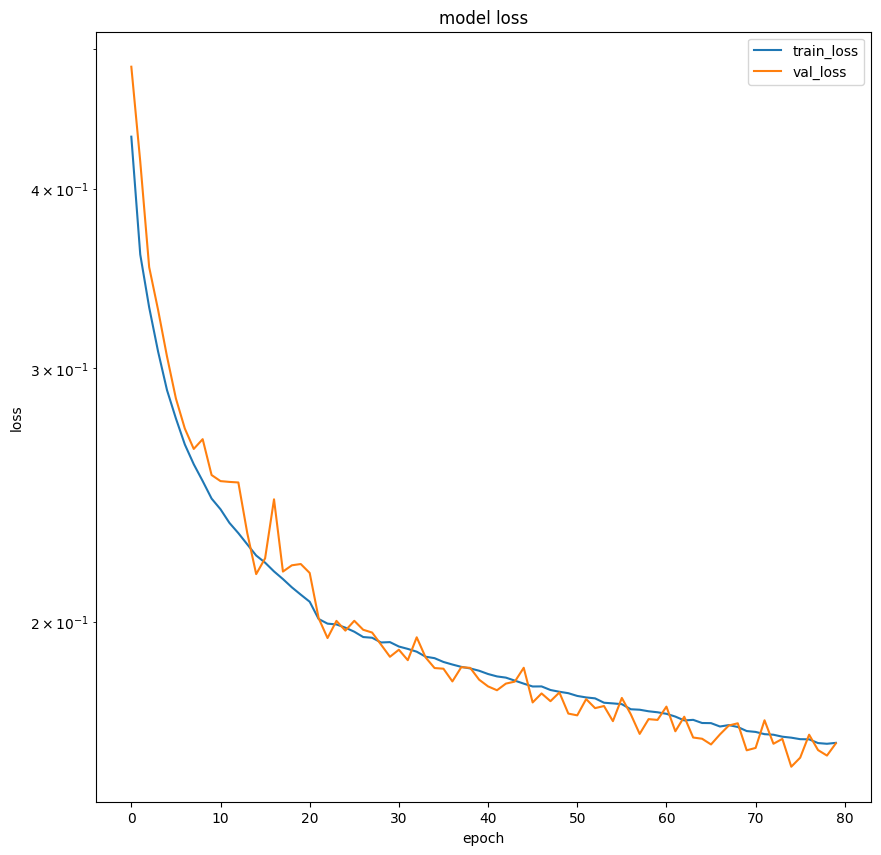

In [14]:
# 这段代码用于可视化模型训练过程中损失值的变化

plt.figure(figsize=(10, 10))   #创建图形对象,设置图形大小为 10x10 英寸
plt.semilogy(eddynet.history.history['loss'])
# 使用 semilogy 函数绘制训练损失（loss）的变化。
# semilogy 使用对数刻度显示 y 轴的值，可以更好地展示损失值的变化

plt.semilogy(eddynet.history.history['val_loss'])
# 使用 semilogy 函数绘制验证损失（val_loss）的变化。

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# 设置图表标题为 "model loss"。
# 设置 y 轴标签为 "loss"。
# 设置 x 轴标签为 "epoch"。

plt.legend(['train_loss', 'val_loss'], loc='upper right');
# 添加图例，说明两条曲线分别表示训练损失和验证损失。
# 将图例放置在右上角（upper right）。

In [12]:
SSH_test = np.expand_dims(np.load(r'D:\jupyterProject\eddy\data\2023\npyData\trainSla_2023_nanhai.npy'),3) #you can use all the region, in here I selected a box of 168*168 size
# np.expand_dims(..., 3)：expand_dims 函数用于在数组中增加一个新的轴。参数 3 表示新轴被添加在原数组的第四个维度（索引从0开始）。这通常用于确保数据的维度与某些特定的数据处理或机器学习模型的输入要求相匹配。
#######
Seg_test = np.expand_dims(np.load(r'D:\jupyterProject\eddy\data\2023\npyData\trainEddy_2023_nanhai.npy'),3)

SSH_test.shape
#####
Seg_test.shape

(365, 88, 80, 1)

(365, 88, 80, 1)

In [13]:
Seg_test_categor = to_categorical(np.reshape(Seg_test[:,:,:,0],(365,88*80)),3)
Seg_test_categor.shape

(365, 7040, 3)

12/12 [==============================] - 4s 179ms/step - loss: 0.1756 - categorical_accuracy: 0.9417 - dice_coef_anti: 0.8143 - dice_coef_cyc: 0.8154 - dice_coef_nn: 0.9653 - mean_dice_coef: 0.8650 - weighted_mean_dice_coef: 0.8203
loss: 0.1755533665418625
categorical_accuracy: 0.9417173862457275
dice_coef_anti: 0.8142512440681458
dice_coef_cyc: 0.8153942227363586
dice_coef_nn: 0.9653467535972595
mean_dice_coef: 0.864997386932373
weighted_mean_dice_coef: 0.8203024864196777


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Anti-cyclonic Eddy Dice Coefficient')

Text(0, 0.5, 'Dice Coefficient')

Text(0.5, 0, 'Epoch')

<Axes: >

Text(0.5, 1.0, 'Cyclonic Eddy Dice Coefficient')

Text(0, 0.5, 'Dice Coefficient')

Text(0.5, 0, 'Epoch')

<Axes: >

Text(0.5, 1.0, 'Non-eddy Area Dice Coefficient')

Text(0, 0.5, 'Dice Coefficient')

Text(0.5, 0, 'Epoch')

<Figure size 1200x800 with 0 Axes>

Text(0.5, 1.0, 'Categorical Accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

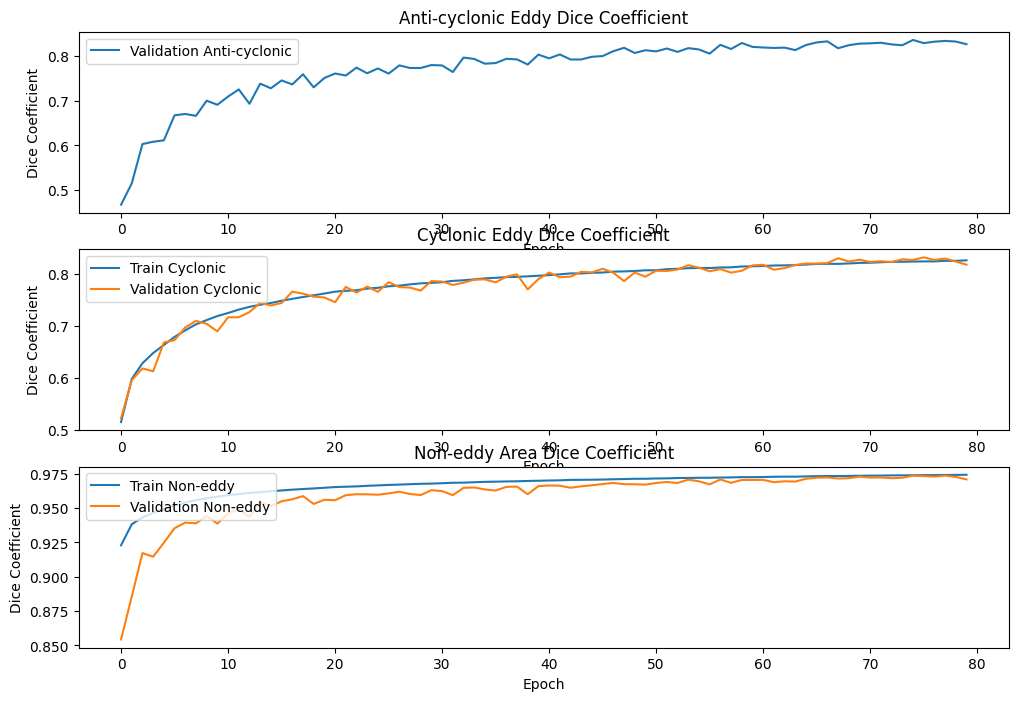

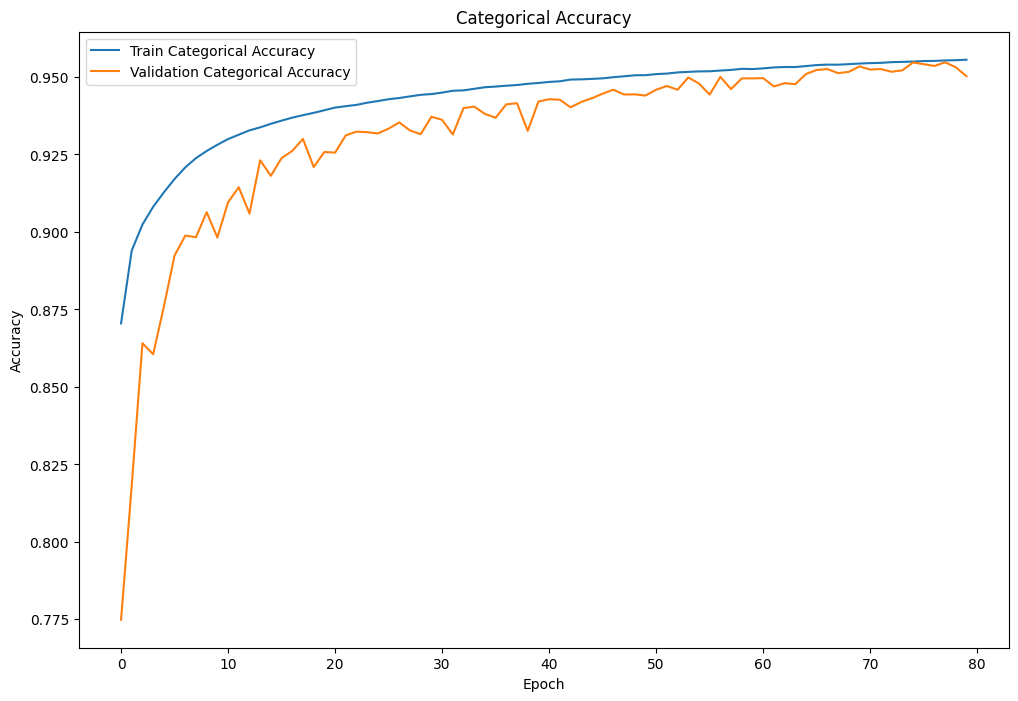

In [23]:
eddynet = load_model(r'D:\EddyNet\EddyNet-master\EddyNet_new\weights\ResNet_FPN_Attention_4e-5.keras', 
                     custom_objects={'dice_coef_anti': dice_coef_anti, 
                                     'dice_coef_cyc': dice_coef_cyc, 
                                     'dice_coef_nn': dice_coef_nn,
                                     'mean_dice_coef': mean_dice_coef,
                                     'weighted_mean_dice_coef': weighted_mean_dice_coef,
                                     'dice_coef_loss': dice_coef_loss,
                                     'Attention_block': Attention_block})  # 确保 categorical_accuracy 被包括在内

# 加载训练历史记录
with open('train_history_ResNet_FPN_Attention_4e-5.npy', 'rb') as f:
     histeddynet = np.load(f, allow_pickle=True).item()

# 现在可以直接评估模型
results = eddynet.evaluate(SSH_test, Seg_test_categor)
for name, value in zip(eddynet.metrics_names, results):
    print(f"{name}: {value}")
 





# 绘制历史记录
plt.figure(figsize=(12, 8))

# 反气旋涡的Dice系数
plt.subplot(311)
#plt.plot(histeddynet['dice_coef_anti'], label='Train Anti-cyclonic')
plt.plot(histeddynet['val_dice_coef_anti'], label='Validation Anti-cyclonic')
plt.title('Anti-cyclonic Eddy Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# 气旋涡的Dice系数
plt.subplot(312)
plt.plot(histeddynet['dice_coef_cyc'], label='Train Cyclonic')
plt.plot(histeddynet['val_dice_coef_cyc'], label='Validation Cyclonic')
plt.title('Cyclonic Eddy Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# 无涡旋区域的Dice系数
plt.subplot(313)
plt.plot(histeddynet['dice_coef_nn'], label='Train Non-eddy')
plt.plot(histeddynet['val_dice_coef_nn'], label='Validation Non-eddy')
plt.title('Non-eddy Area Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# 新增 categorical_accuracy 的绘图
plt.figure(figsize=(12, 8))
plt.plot(histeddynet['categorical_accuracy'], label='Train Categorical Accuracy')
plt.plot(histeddynet['val_categorical_accuracy'], label='Validation Categorical Accuracy')
plt.title('Categorical Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [24]:
import plotly.graph_objects as go

# 假设 histeddynet 包含损失值数据
# 示例数据
epochs = list(range(1, len(histeddynet['loss']) + 1))

# 创建训练损失的折线图
train_loss_trace = go.Scatter(
    x=epochs,
    y=histeddynet['loss'],
    mode='lines+markers',
    name='Train Loss',
    line=dict(color='blue'),
    marker=dict(size=8)
)

# 创建验证损失的折线图
val_loss_trace = go.Scatter(
    x=epochs,
    y=histeddynet['val_loss'],
    mode='lines+markers',
    name='Validation Loss',
    line=dict(color='red'),
    marker=dict(size=8)
)

# 创建图形对象
fig = go.Figure()

# 添加数据到图形中
fig.add_trace(train_loss_trace)
fig.add_trace(val_loss_trace)

# 设置图表标题和坐标轴标签
fig.update_layout(
    title='Model Loss',
    xaxis=dict(
        title='Epoch',
        tickmode='linear',
        tickfont=dict(size=16),
        titlefont=dict(size=18)
    ),
    yaxis=dict(
        title='Loss',
        type='log',  # 设置 y 轴为对数刻度
        tickfont=dict(size=16),
        titlefont=dict(size=18),
        showexponent='none'  # 取消科学计数法显示
    ),
    font=dict(
        family='Times New Roman',
        size=20
    ),
    legend=dict(
        title=None,
        font=dict(size=14),
        x=0.8,
        y=1.0
    ),
    width=800,
    height=600
)

# 显示图表
fig.show()

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 预测结果
predictions = eddynet.predict(SSH_test)
predictions = np.argmax(predictions, axis=-1).reshape(-1)

# 真实标签
true_labels = np.argmax(Seg_test_categor, axis=-1).reshape(-1)

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 计算分类报告
report = classification_report(true_labels, predictions, target_names=['No Eddy', 'Cyclonic Eddy', 'Anticyclonic Eddy'])
print("Classification Report:")
print(report)

12/12 [==============================] - 3s 198ms/step
Confusion Matrix:
[[2082429   36478   59755]
 [  25220  155203       3]
 [  21053       0  189459]]
Classification Report:
                   precision    recall  f1-score   support

          No Eddy       0.98      0.96      0.97   2178662
    Cyclonic Eddy       0.81      0.86      0.83    180426
Anticyclonic Eddy       0.76      0.90      0.82    210512

         accuracy                           0.94   2569600
        macro avg       0.85      0.91      0.88   2569600
     weighted avg       0.95      0.94      0.95   2569600



1/1 [==============================] - 0s 40ms/step


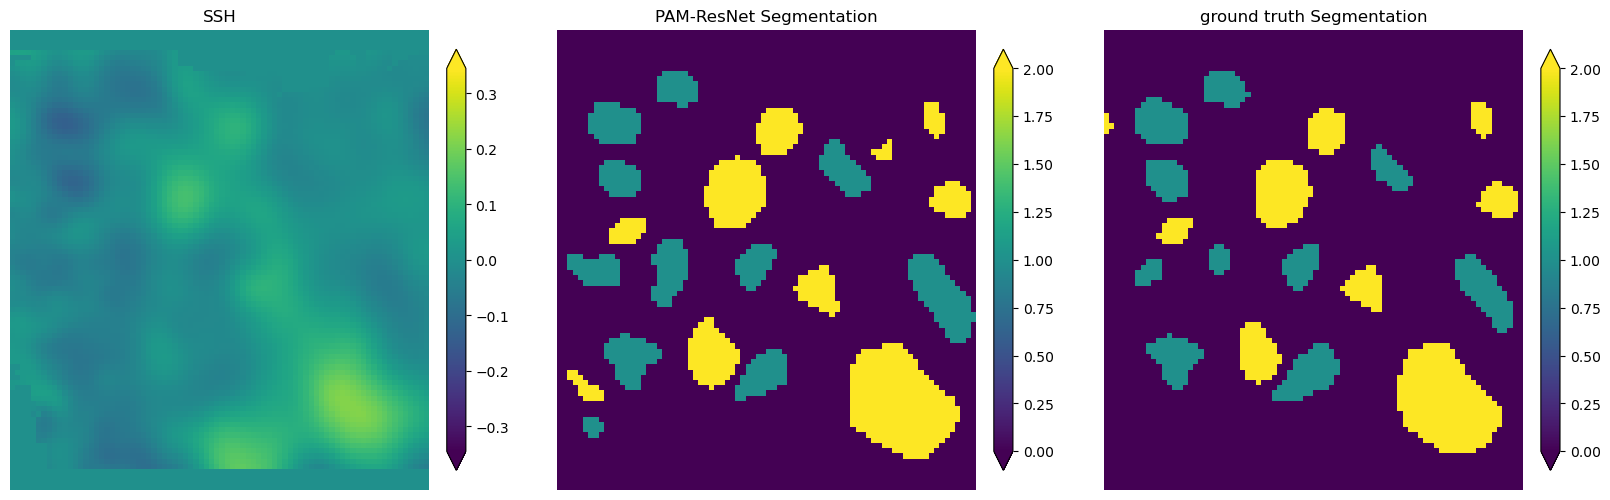

In [34]:
randindex=np.random.randint(0,len(SSH_train))
predictedSEGM=eddynet.predict(np.reshape(SSH_train[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis',vmin=-0.345, vmax=0.345)
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('PAM-ResNet Segmentation');

plt.subplot(133)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');